# Importing libraries

In [1]:
!pip install rpy2==2.9.6b

     |████████████████████████████████| 194 kB 5.6 MB/s 
  Created wheel for rpy2: filename=rpy2-2.9.6b0-cp37-cp37m-linux_x86_64.whl size=318401 sha256=bf03453bbe2daa4438f89532ebbb9e8d500b16eb9ca39bf75407a87172e5af2b
  Stored in directory: /root/.cache/pip/wheels/95/f5/ca/0ac73de2f1358e0964d50de50ce75d8d096156f829836076d6
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.5
    Uninstalling rpy2-3.4.5:
      Successfully uninstalled rpy2-3.4.5


In [2]:
%load_ext rpy2.ipython


/usr/local/lib/python3.7/dist-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [ ]:
%%R
install.packages("grf")

In [ ]:
#!pip install justcause #==0.3.2  Note the version of JustCause we are using in case you are looking into the documentation
!git clone https://github.com/solalatus/justcause.git
%cd justcause/
!git checkout keras_hack
!pip install git+file:///content/justcause

In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
from justcause.data import Col
from justcause.data.sets import load_ihdp
from justcause.metrics import pehe_score, mean_absolute
from justcause.evaluation import calc_scores, summarize_scores

In [2]:
%load_ext autoreload

%autoreload 2

# Loading all required packages 
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Infant Health Development Program Data-Set

- Original study constructed to study the effect of special child care for low birthweight, premature infants.
- In total, six continuous and 19 binary pretreatment variables
- Using the covariates of all instances in both treatment groups, the potential outcomes are generated synthetically
- Finally, manipulation of observational study by omitting a non-random set of samples from the treatment group.
- The way the subset is generated from the experimental data does not ensure complete overlap - latent confounder
- Specifically, the observational subset is created by throwing away the set of all children with nonwhite mothers from the treatment group
- Following data generation process used for potentia outcomes
- After the adaptions from Hill, we are left with 139 instances in the treated group and 608 instances in the control group.

Brief Intro

1.   ITE vs ATE vs CATE: We are always interested in individual treatment effect so this can be incorporated in making some decision. Example: In case of advertising if we know (by some Oracle means) that by sending the email to person A the conversion chance increase by 5% then we can incorporate this in our analysis or decision making. However as we know Fundamental problem of Causal Inference we either know Y(1) or Y(0) and are trying to find this difference by using the counterfactual. Therefore we try different means like estimating this difference over the population and assume that this holds for individuals too. However therefore could be some confounder which affects the outcomes of treatment and therefore in that case it is better to condition on this confounder and hence use CATE instead of ATE.
2.   WHY NOT RCT: In RCT also we get the CATE beacuse effectively we create statistical twin set (considering all covariates/features) and then randomly select one set for treatment and other for control. However the problems is Data is not easily available and is difficult to be generated owing to its nature.
3. Data Generating Process: In order to be able to evaluate methods, we thus need to resort to semi- or fully-synthetic data. The process
of generating such a dataset is called a data generating process (DGP). In partially synthetic approach we create only treatment and/or outcome assignment
and use real covariates, however in fully synthetic we create even covariates by sampling them from some distribution. This is partially synthetic dataset. Further a replication is generated by sampling from the probability distributions that define the data. In the case of IHDP 1000 replications of the same data are created.
4. As mentioned Overlap condition is not adhered as Control group while has children from both white and non-white mothers its not their in case of Treatment, which itself violates the one of the three main principle of DGP(Overlap, Unconfoundedness and SUTVA). Therefore strong ingnorability cannot cannot be assumed here.






# 1. Running the causal models

In [3]:
# We Import the IHDP data-set 
# There are 1000 replications in this data-set, each with a different individual treament effect
# produced from an underlying generative function. 
# Check out https://justcause.readthedocs.io/en/latest/

# We load 100 of the 1000 data-sets
replications = load_ihdp(select_rep=np.arange(100))

In [4]:
# Defining global parameters
train_size = 0.8        # Size of the training data-set 
random_state = 42        # Setting the random state

n= 0       # number of the data-sets we look at for visualization

metrics = [pehe_score, mean_absolute]    ## Defining the metrics that will be calculated below

## 1.1 S-Learner Linear Regression

In [5]:
# Importing the relevant SLearner module

from justcause.learners import SLearner

# Defining the S-Learner function that returns the ITE
# We define a function that takes the data, splits it up and returns individual treatment effect accuracies for the train and the test data-set
# The function takes each, the train and test data separately and selects the relevant variables and coverts them into np arrays
# The relevant variables have the followings names: x (the covariates), t (the treatment), y (the outcome)
# Note that the treatment needs to be explicityl defined


def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model     # Select linear regression as a method to find the ITE for the S-Learner
    slearner.fit(train_X, train_t, train_y)      # Fitting the s-learner with linear regression
    return (
        slearner.predict_ite(train_X, train_t, train_y),   # Returning the predicting values for ITE for train
        slearner.predict_ite(test_X, test_t, test_y)       # Returning the prediction values for ITE for test
    )



In [ ]:

def evaluateModels(learnerType,model,data):
    test_scores = list()    # Storing the test scores in a list
    train_scores = list()
    for rep in data:

        train, test = train_test_split(
            rep, train_size=train_size, random_state=random_state
        )

        # REPLACE this with the function you implemented and want to evaluate
        train_ite, test_ite = learnerType(train, test, model)

        # Calculate the scores and append them to a dataframe
        train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
        test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

    return train_scores, test_scores


In [6]:
results_df = list()     # We define the list that contains the results


# Passing Linear Regression in S-learner

sLearnerLR = SLearner(LinearRegression())
train_scores, test_scores = evaluateModels(basic_slearner,sLearnerLR,replications)

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})
results_df.append(train_result)
results_df.append(test_result)

In [7]:
df_S_learner_LR=pd.DataFrame([train_result, test_result])

df_S_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False


### 1.1.1 S-Learner Visualization ( for replications n = 0)

In [8]:
# We run the same analysis again but only on an indvidual run of the data
# The reason is that the data generating process is varied every time,... 
# ...so we can only look at individual runs of the ITE effect
results_df = list()    # We define the list that contains the results
test_scores = list()   # Storing the test scores in a list
train_scores = list()  # Storing the train scores in a list


train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state    
    )


train_ite, test_ite = basic_slearner(train, test, sLearnerLR)         # using the pre-defined basic learner function to retunr train, test

train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))    # Using the just cause API to calcualte the scores from the estimate ITE for the training data
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))     # Using the just cause API to calcualte the scores from the estimate ITE for the test data

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)   #summary of the scores 
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


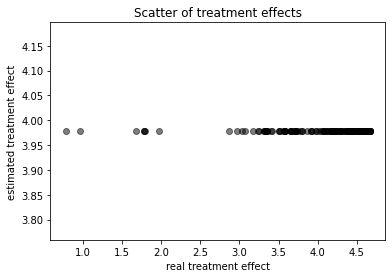

In [9]:
# Importing Matplotlib 
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

# If the treatment effect is perfectly represented there should be a 45 degree line!

## 1.2 Propensity Score Weighing with Linear Regression

In [10]:
# Importing the relevant PSWEstimator

from justcause.learners import PSWEstimator


#Defining the Propoensity Score weighing function that returns the ITE

def propensity_score_weighing(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    pswestimator = model

    return (
        pswestimator.estimate_ate(train_X, train_t, train_y),
        pswestimator.estimate_ate(test_X, test_t, test_y)
    )


In [11]:

model = PSWEstimator(propensity_learner=None, delta=0.001)
train_scores, test_scores = evaluateModels(propensity_score_weighing, model, replications)

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'PSW', 'train': True})
test_result.update({'method': 'PSW', 'train': False})

results_df.append(train_result)
results_df.append(test_result)

In [12]:
df_PSW_LR=pd.DataFrame([train_result, test_result])
df_PSW_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
1,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False


## 1.3 S-Learner Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [14]:

sLearnerRF = SLearner(RandomForestRegressor(random_state= random_state))
train_scores, test_scores = evaluateModels(basic_slearner,sLearnerRF, replications)


train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner RF', 'train': True})
test_result.update({'method': 'S-Learner RF', 'train': False})
results_df.append(train_result)
results_df.append(test_result)

In [15]:
df_S_learner_RF=pd.DataFrame([train_result, test_result])
df_S_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,3.103431,1.042752,4.782134,0.506913,0.130858,0.958173,S-Learner RF,True
1,3.303456,1.232679,5.152432,0.455873,0.138632,1.055254,S-Learner RF,False


SLearner RF visualization

In [16]:

results_df = list()    # We define the list that contains the results
test_scores = list()   # Storing the test scores in a list
train_scores = list()  # Storing the train scores in a list


train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state     
    )

train_ite, test_ite = basic_slearner(train, test, sLearnerRF)         # using the pre-defined basic learner function to retunr train, test

train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))    # Using the just cause API to calcualte the scores from the estimate ITE for the training data
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))     # Using the just cause API to calcualte the scores from the estimate ITE for the test data

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)   #summary of the scores 
train_result.update({'method': 'S-Learner RF', 'train': True})
test_result.update({'method': 'S-Learner RF', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


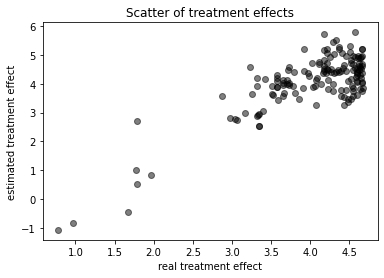

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## 1.4 T-Learner Linear Regression

In [17]:
# Importing the relevant TLearner module

from justcause.learners import TLearner


#Defining the T-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [18]:
tlearnerLR = TLearner(LinearRegression())
train_scores, test_scores = evaluateModels(basic_tlearner,tlearnerLR, replications)

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})
results_df.append(train_result)
results_df.append(test_result)

In [19]:
df_T_learner_LR=pd.DataFrame([train_result, test_result])
df_T_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
1,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False


### 1.4.1 T-Learner Linear Regression Visualization

In [20]:
results_df = list()
test_scores = list()
train_scores = list()

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

train_ite, test_ite = basic_tlearner(train, test, tlearnerLR)

train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


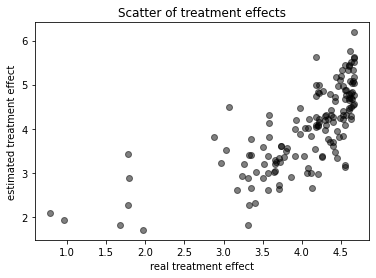

In [21]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## 1.5 T-Learner Random Forest

In [22]:
# Importing the relevant TLearner module

from justcause.learners import TLearner


#Defining the T-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [23]:
tLearnerRF = TLearner(RandomForestRegressor(random_state= random_state))
train_scores, test_scores = evaluateModels(basic_tlearner,tLearnerRF, replications)


train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

results_df.append(train_result)
results_df.append(test_result)

In [24]:
df_T_learner_RF=pd.DataFrame([train_result, test_result])
df_T_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,1.789142,0.963095,2.264893,0.125687,0.091743,0.126149,T-Learner RF,True
1,2.508365,1.125215,3.481669,0.212099,0.111783,0.280373,T-Learner RF,False


### 1.5.1 T-Learner with Random Forrest Visualization

In [25]:

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

train_ite, test_ite = basic_tlearner(train, test, tLearnerRF)

train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


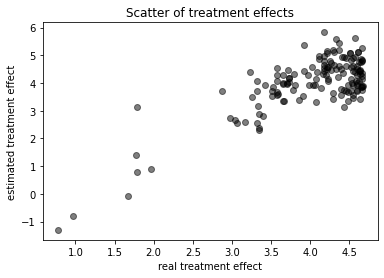

In [26]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## 1.6 Causal Forest

In [27]:
# Importing the relevant SLearner module

from justcause.learners import CausalForest


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    causalforest = CausalForest(random_state=random_state)
    causalforest.fit(train_X, train_t, train_y)
    return (
        causalforest.predict_ite(train_X, train_t, train_y),
        causalforest.predict_ite(test_X, test_t, test_y)
    )


In [28]:
random_state = 1


causalRF = CausalForest(random_state=random_state)
train_scores, test_scores = evaluateModels(causal_forest,causalRF, replications)


train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Causal Forest', 'train': True})
test_result.update({'method': 'Causal Forest', 'train': False})
results_df.append(train_result)
results_df.append(test_result)

In [29]:
df_causal_forest=pd.DataFrame([train_result, test_result])
df_causal_forest

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,4.172661,1.921242,6.330031,0.441738,0.198733,0.823171,Causal Forest,True
1,4.378083,1.797608,6.606150,0.683703,0.233695,1.354973,Causal Forest,False


### 1.6.1 Causal Forest Visualization 

In [30]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

train_ite, test_ite = causal_forest(train, test, causalRF)

train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Causal Forest', 'train': True})
test_result.update({'method': 'Causal Forest', 'train': False})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


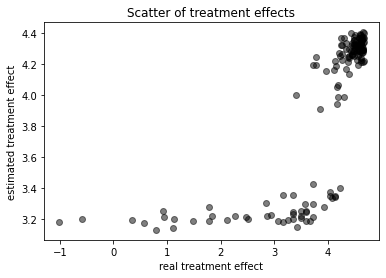

In [31]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## 1.7 Neural Network

In [32]:
# Importing the relevant SLearner module

from justcause.learners import DragonNet


#Defining the S-Learner function that returns the ITE

def dragon_net(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    dragonnet = model
    dragonnet.fit(train_X, train_t, train_y)
    return (
        dragonnet.predict_ite(train_X, train_t, train_y),
        dragonnet.predict_ite(test_X, test_t, test_y)
    )


In [ ]:
random_state = 1


dragonnet_ = DragonNet()


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    train_ite, test_ite = dragon_net(train, test, dragonnet_)

    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

In [ ]:
df_dragonnet=pd.DataFrame([train_result, test_result])
df_dragonnet

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.801530,1.118610,4.712027,0.790784,0.354236,1.558654,Dragonnet,True
1,2.913926,1.077568,4.699833,0.867828,0.338806,1.922767,Dragonnet,False


### 1.7.1 Neura Network Visualization

In [ ]:
random_state = 1


train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = dragon_net(train, test, dragonnet_)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
2/2 [==============================] - 2s 423ms/step - loss: 13908.1904 - regression_loss: 3770.7336 - val_loss: 1486.6659 - val_regression_loss: 725.1031 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 9976.8965 - regression_loss: 2580.2891 - val_loss: 972.0479 - val_regression_loss: 463.5086 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - 0s 32ms/step - loss: 6147.6680 - regression_loss: 1541.3311 - val_loss: 551.2032 - val_regression_loss: 246.3246 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - 0s 33ms/step - loss: 3463.0161 - regression_loss: 815.0209 - val_loss: 393.7396 - val_regression_loss: 165.2733 - lr: 0.0010
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 3102.0378 - regression_loss: 696.0798 - val_loss: 320.4322 - val_regression_loss: 135.4087 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 34ms/step - loss: 2607.4778 - regression_loss: 603.6948 - val_loss

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


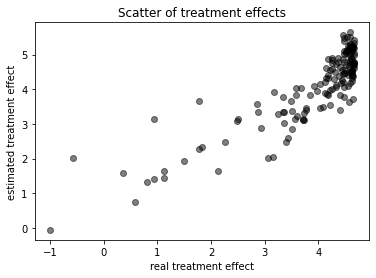

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## 1.8 Comparison of the methods

In [ ]:
pd.concat([df_S_learner_LR, df_PSW_LR, df_S_learner_RF, df_T_learner_LR, df_T_learner_RF, df_causal_forest, df_dragonnet ], ignore_index=True)

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False
2,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
3,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False
4,3.103431,1.042752,4.782134,0.506913,0.130858,0.958173,S-Learner RF,True
5,3.303456,1.232679,5.152432,0.455873,0.138632,1.055254,S-Learner RF,False
6,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
7,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False
8,1.789142,0.963095,2.264893,0.125687,0.091743,0.126149,T-Learner RF,True
9,2.508365,1.125215,3.481669,0.212099,0.111783,0.280373,T-Learner RF,False
